### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [ ]:
#Q1

import numpy as np

data = np.load('/Users/harvir_d/NEW_repos/astr_8070_s25/coursework/homeworks/hw_data/hw8_data_1.npy')

print(data.dtype.names) # printing column names from dataset

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


In [8]:
#Q1 Continued

# extracting color arrays, redshift, and spectral class by accessing column names

u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

redshift = data['redshift']
spec_class = data['specClass']

unique_classes, counts = np.unique(spec_class, return_counts=True) # returning two arrays, one is a label array [galaxy, quasar], and one is the number of counts associated with each of galaxy, quasar
for cls, count in zip(unique_classes, counts): # pairing and then printing each class in [galaxy, quasar] with its associated number of counts in the data
    print(f"Class {cls}: {count} objects")


Class GALAXY: 42808 objects
Class QSO: 7192 objects


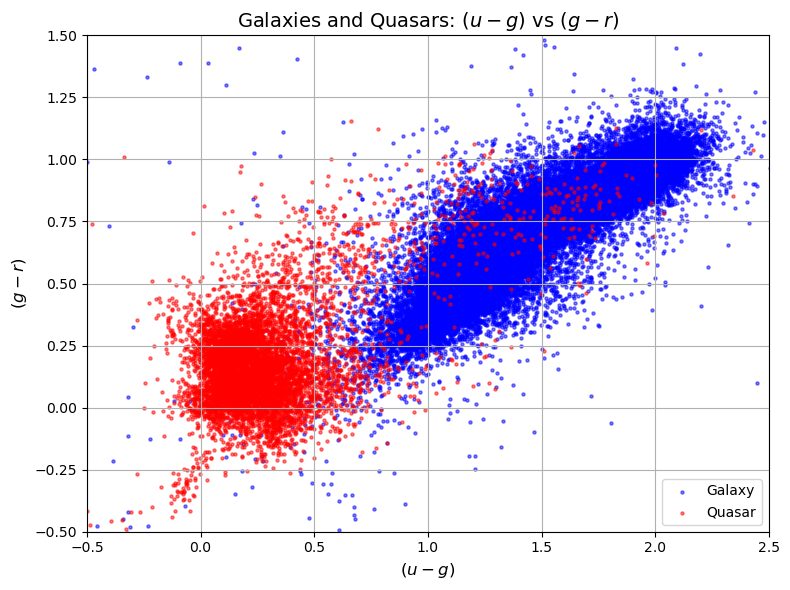

In [9]:
#Q2

import matplotlib.pyplot as plt

is_galaxy = data['specClass'] == 'GALAXY' # boolean mask determines what is a galaxy and what is a quasar
is_quasar = data['specClass'] == 'QSO'

plt.figure(figsize=(8, 6))

plt.scatter(u_g[is_galaxy], g_r[is_galaxy], color='blue', s=5, label='Galaxy', alpha=0.5) # specifying colors plotted by galaxy or quasar object

plt.scatter(u_g[is_quasar], g_r[is_quasar], color='red', s=5, label='Quasar', alpha=0.5)

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)

plt.xlabel(r'$(u - g)$', fontsize=12)
plt.ylabel(r'$(g - r)$', fontsize=12)
plt.title('Galaxies and Quasars: $(u-g)$ vs $(g-r)$', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Q3

from astroML.utils import split_samples

#stack all features into a single data matrix X
X = np.column_stack([u_g, g_r, r_i, i_z, redshift])  # shape (N, 5) where N is the number of observations in the data

#0 for galaxy, 1 for quasar
y = np.zeros(len(data), dtype=int)
y[data['specClass'] == 'QSO'] = 1  #using Boolean condition for distinguishing classes

#split into training and testing sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.8,0.2], random_state=0)

#check shapes to confirm
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 40000
Testing set size: 10000


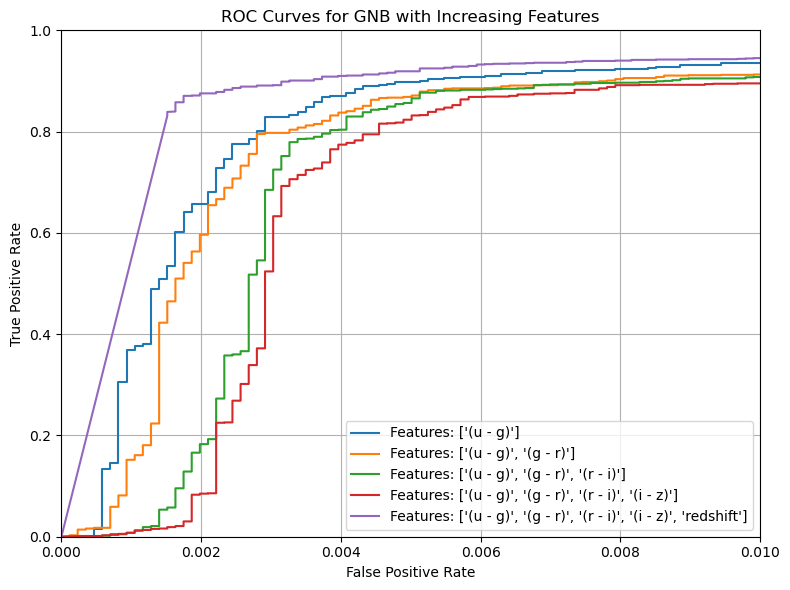

In [ ]:
#Q4

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

# Feature names for labeling
feature_labels = ['(u - g)', '(g - r)', '(r - i)', '(i - z)', 'redshift']

plt.figure(figsize=(8, 6))

for i in range(1, 6):
    # Select the first i features
    X_train_subset = X_train[:, :i]
    X_test_subset = X_test[:, :i]
    
    # Fit the GNB model
    model = GaussianNB()
    model.fit(X_train_subset, y_train)
    
    # Predict probabilities for class 1
    probs = model.predict_proba(X_test_subset)
    
    # Find the index corresponding to class 1 (quasar)
    quasar_index = list(model.classes_).index(1)
    y_scores = probs[:, quasar_index]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    plt.plot(fpr, tpr, label=f'Features: {feature_labels[:i]}')

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GNB with Increasing Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Just the first feature in the (u-g) color makes classification trivially easy, as it is close to the top left of this plot (high TPR, low FPR). All 5 features together is best for classification, but just the first feature alone does a good job of it. I am thinking the other features introduce correlations that cause the curves to move further to the right after the case of one feature. The correlations would make the underlying GNB assumptions of independent features difficult to justify. Then, I suppose with all five features, the "true" signal is greater than any sort of correlation noise, and so the 5-feature case is best.

SRT: I see your point, but you can also see a huge change whenever redshift is introduced. That's the key feature here. -1 point.

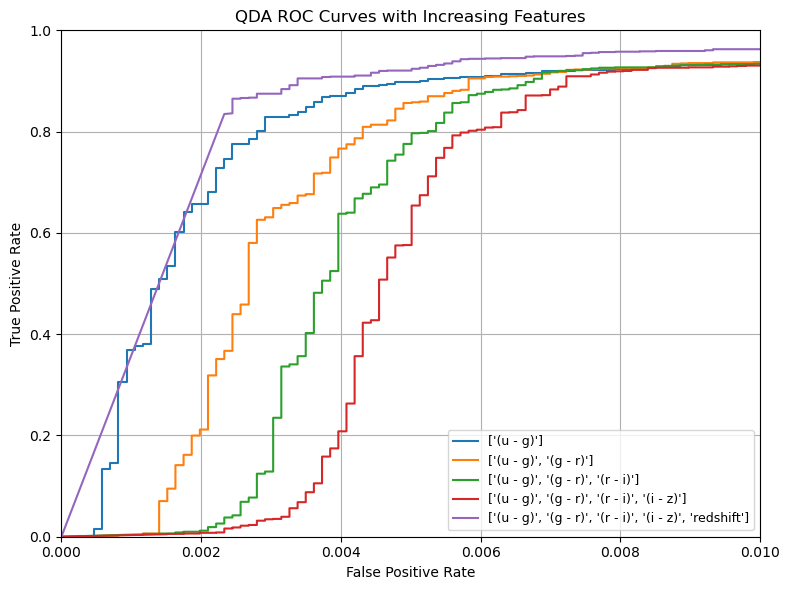

In [17]:
#Q5

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Feature names for labeling
feature_labels = ['(u - g)', '(g - r)', '(r - i)', '(i - z)', 'redshift']

plt.figure(figsize=(8, 6))

for i in range(1, 6):
    # Select first i features
    X_train_subset = X_train[:, :i]
    X_test_subset = X_test[:, :i]
    
    # Fit QDA
    model = QDA()
    model.fit(X_train_subset, y_train)
    
    # Predict probabilities for class 1
    probs = model.predict_proba(X_test_subset)
    
    # Find the index corresponding to class 1 (quasar)
    quasar_index = list(model.classes_).index(1)
    y_scores = probs[:, quasar_index]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    plt.plot(fpr, tpr, label=f'{feature_labels[:i]}')

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('QDA ROC Curves with Increasing Features')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


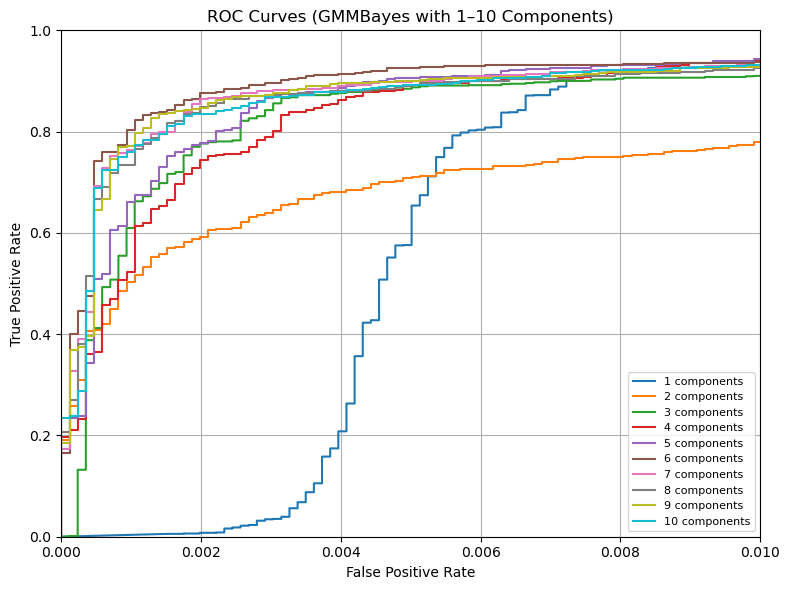

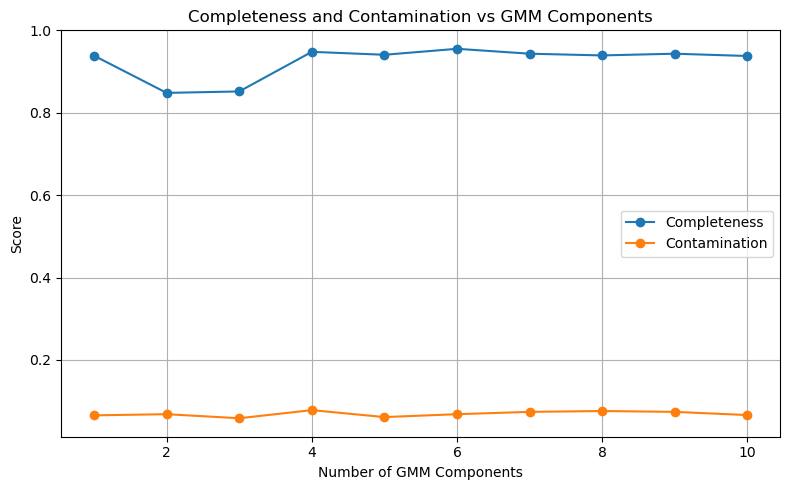

In [ ]:
#Q6

from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination

# Use only the 4 color features
X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]

# Range of number of GMM components to try
n_components_range = np.arange(1, 11)

# Lists to store completeness and contamination for each model
completeness_list = []
contamination_list = []

# Set up ROC curve plot
plt.figure(figsize=(8, 6))

for n_components in n_components_range:
    # Fit GMMBayes model
    clf = GMMBayes(n_components=n_components)
    clf.fit(X_train_colors, y_train)

    # Predict class probabilities
    probs = clf.predict_proba(X_test_colors)
    quasar_index = list(clf.classes_).index(1)
    y_scores = probs[:, quasar_index]

    # Predict class labels
    y_pred = clf.predict(X_test_colors)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{n_components} components')

    # Compute completeness and contamination
    completeness, contamination = completeness_contamination(y_test, y_pred)
    completeness_list.append(completeness)
    contamination_list.append(contamination)

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (GMMBayes with 1–10 Components)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n_components_range, completeness_list, label='Completeness', marker='o')
plt.plot(n_components_range, contamination_list, label='Contamination', marker='o')
plt.xlabel('Number of GMM Components')
plt.ylabel('Score')
plt.title('Completeness and Contamination vs GMM Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



SRT: No statement of best number of components for classifier here or for the next few parts? Needs some assessment of best ROC performer using area under the curve. EDIT: OK I looked further down, and you did do some quantitative assessment with completeness/contamination, but you also mention that it could be done better. -1 points.

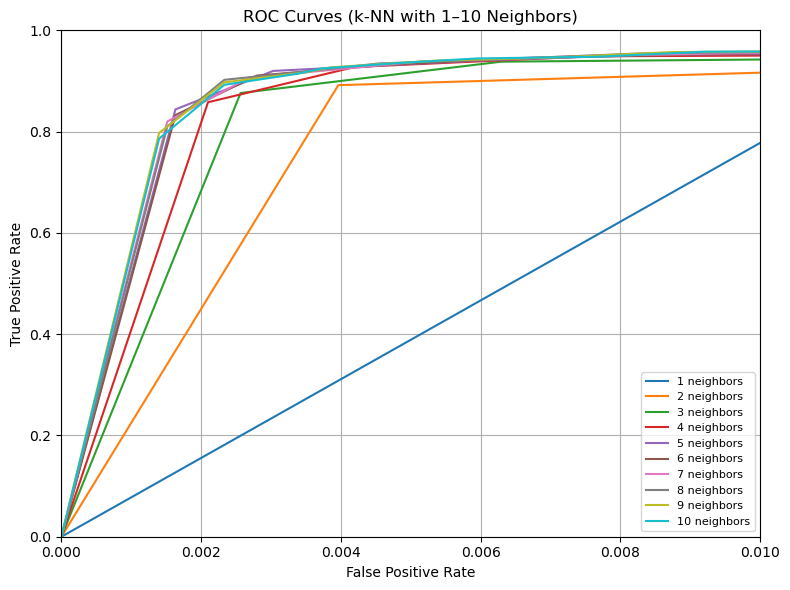

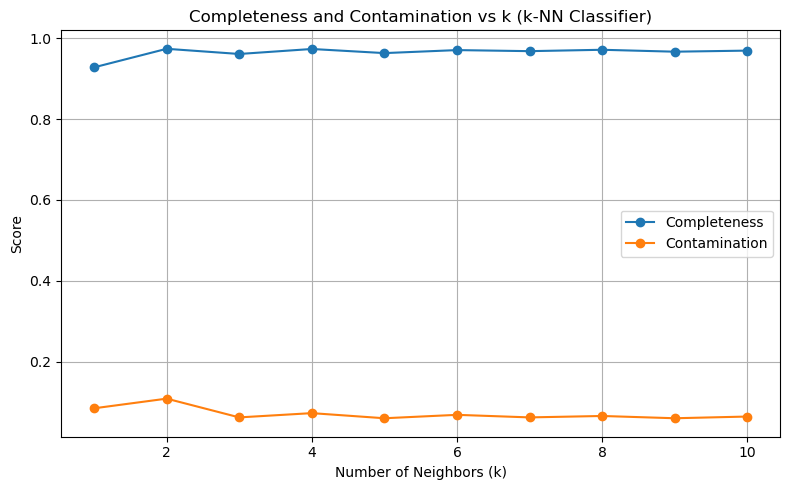

In [21]:
#Q7

from sklearn.neighbors import KNeighborsClassifier

# Use only the 4 color features
X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]

# Range of neighbor values to test
n_neighbors_range = np.arange(1, 11)

# Lists to store completeness and contamination for each model
completeness_list = []
contamination_list = []

# ROC plot
plt.figure(figsize=(8, 6))

for n_neighbors in n_neighbors_range:
    # Fit k-NN model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_colors, y_train)

    # Predict class probabilities
    probs = clf.predict_proba(X_test_colors)
    quasar_index = list(clf.classes_).index(1)
    y_scores = probs[:, quasar_index]

    # Predict class labels
    y_pred = clf.predict(X_test_colors)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{n_neighbors} neighbors')

    # Compute completeness and contamination
    completeness, contamination = completeness_contamination(y_test, y_pred)
    completeness_list.append(completeness)
    contamination_list.append(contamination)

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (k-NN with 1–10 Neighbors)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n_neighbors_range, completeness_list, label='Completeness', marker='o')
plt.plot(n_neighbors_range, contamination_list, label='Contamination', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('Completeness and Contamination vs k (k-NN Classifier)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



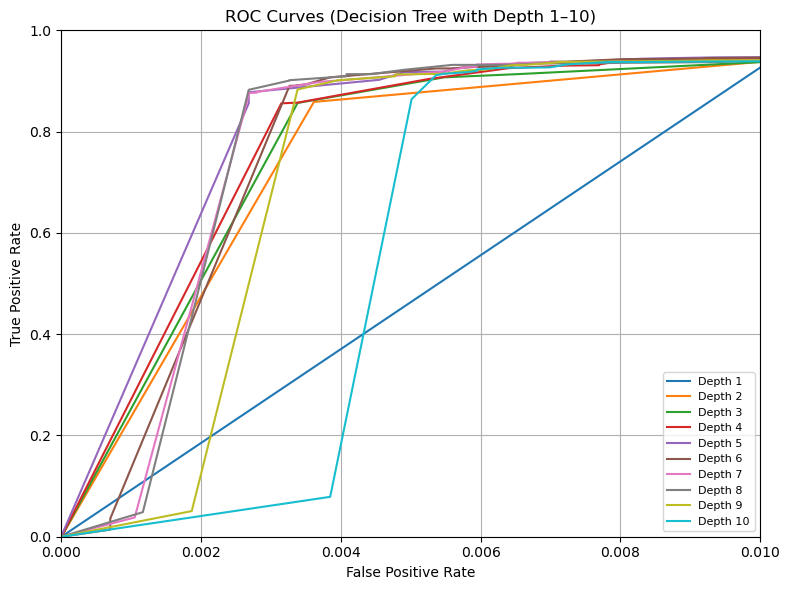

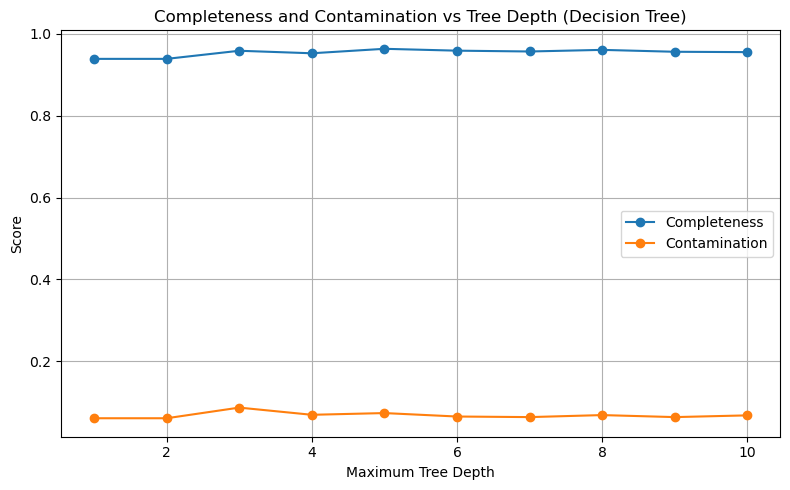

In [22]:
#Q8 

from sklearn.tree import DecisionTreeClassifier

# Use only the 4 color features
X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]

# Tree depths to evaluate
depth_range = np.arange(1, 11)

completeness_list = []
contamination_list = []

# ROC Curve Plot
plt.figure(figsize=(8, 6))

for depth in depth_range:
    # Train Decision Tree with max depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_colors, y_train)
    
    # Predict class probabilities
    probs = clf.predict_proba(X_test_colors)
    quasar_index = list(clf.classes_).index(1)
    y_scores = probs[:, quasar_index]
    
    # Predict class labels
    y_pred = clf.predict(X_test_colors)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'Depth {depth}')
    
    # Completeness & contamination
    completeness, contamination = completeness_contamination(y_test, y_pred)
    completeness_list.append(completeness)
    contamination_list.append(contamination)

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Decision Tree with Depth 1–10)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(depth_range, completeness_list, label='Completeness', marker='o')
plt.plot(depth_range, contamination_list, label='Contamination', marker='o')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Score')
plt.title('Completeness and Contamination vs Tree Depth (Decision Tree)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


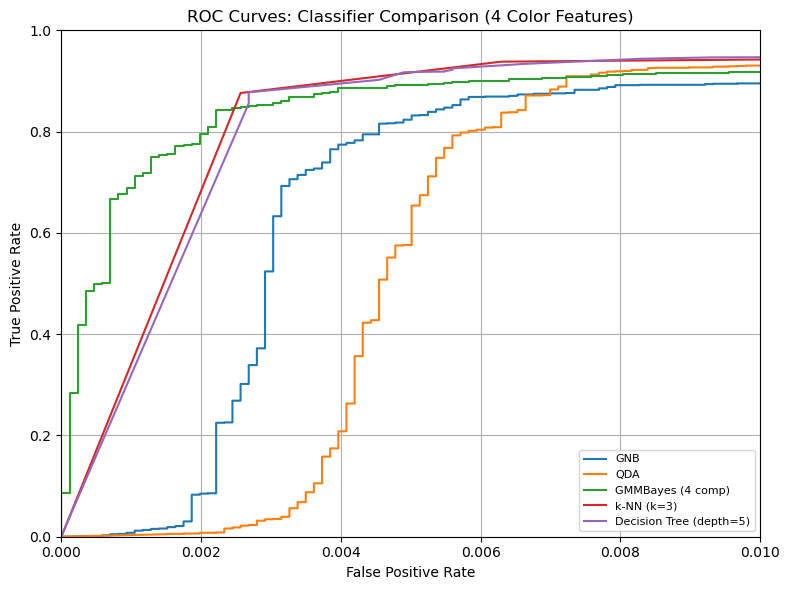

In [23]:
#Q9

# Feature matrix: just the 4 colors
X_train_colors = X_train[:, :4]
X_test_colors = X_test[:, :4]

# Set up ROC plot
plt.figure(figsize=(8, 6))

# 1. GNB
gnb = GaussianNB()
gnb.fit(X_train_colors, y_train)
gnb_probs = gnb.predict_proba(X_test_colors)
gnb_index = list(gnb.classes_).index(1)
fpr, tpr, _ = roc_curve(y_test, gnb_probs[:, gnb_index])
plt.plot(fpr, tpr, label='GNB')

# 2. QDA
qda = QDA()
qda.fit(X_train_colors, y_train)
qda_probs = qda.predict_proba(X_test_colors)
qda_index = list(qda.classes_).index(1)
fpr, tpr, _ = roc_curve(y_test, qda_probs[:, qda_index])
plt.plot(fpr, tpr, label='QDA')

# 3. Best GMMBayes (n_components=4), more sophisticated way of choosing the best n_components for GMM, k-NN, and the tree, I just looked at the completeness/contamination plots above and could have done more explicit calculations here
gmm = GMMBayes(n_components=4)
gmm.fit(X_train_colors, y_train)
gmm_probs = gmm.predict_proba(X_test_colors)
gmm_index = list(gmm.classes_).index(1)
fpr, tpr, _ = roc_curve(y_test, gmm_probs[:, gmm_index])
plt.plot(fpr, tpr, label='GMMBayes (4 comp)')

# 4. Best k-NN (say k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_colors, y_train)
knn_probs = knn.predict_proba(X_test_colors)
knn_index = list(knn.classes_).index(1)
fpr, tpr, _ = roc_curve(y_test, knn_probs[:, knn_index])
plt.plot(fpr, tpr, label='k-NN (k=3)')

# 5. Best Decision Tree (say depth=5)
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(X_train_colors, y_train)
dt_probs = dt.predict_proba(X_test_colors)
dt_index = list(dt.classes_).index(1)
fpr, tpr, _ = roc_curve(y_test, dt_probs[:, dt_index])
plt.plot(fpr, tpr, label='Decision Tree (depth=5)')

plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Classifier Comparison (4 Color Features)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
#Q9 Continued

#determining best classifier with AUC (area under curve) metric

from sklearn.metrics import auc

# AUC for Gaussian Naive Bayes
fpr, tpr, _ = roc_curve(y_test, gnb_probs[:, gnb_index])
print(f"GNB AUC: {auc(fpr, tpr):.4f}")

# AUC for QDA
fpr, tpr, _ = roc_curve(y_test, qda_probs[:, qda_index])
print(f"QDA AUC: {auc(fpr, tpr):.4f}")

# AUC for GMMBayes (n_components = 4)
fpr, tpr, _ = roc_curve(y_test, gmm_probs[:, gmm_index])
print(f"GMMBayes (4 comp) AUC: {auc(fpr, tpr):.4f}")

# AUC for k-NN (k=3)
fpr, tpr, _ = roc_curve(y_test, knn_probs[:, knn_index])
print(f"k-NN (k=3) AUC: {auc(fpr, tpr):.4f}")

# AUC for Decision Tree (depth=5)
fpr, tpr, _ = roc_curve(y_test, dt_probs[:, dt_index])
print(f"Decision Tree (depth=5) AUC: {auc(fpr, tpr):.4f}")


GNB AUC: 0.9745
QDA AUC: 0.9820
GMMBayes (4 comp) AUC: 0.9900
k-NN (k=3) AUC: 0.9770
Decision Tree (depth=5) AUC: 0.9732


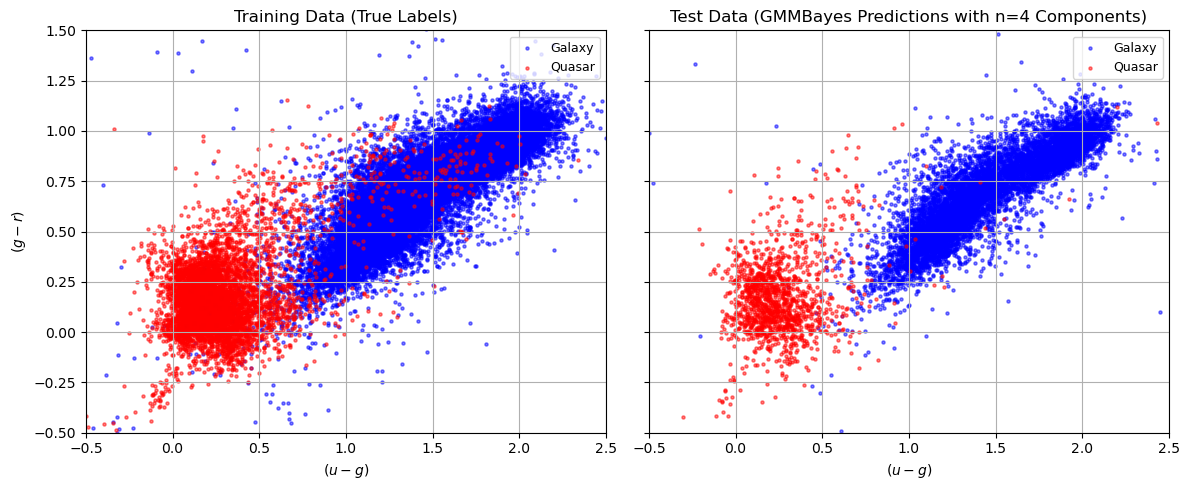

In [28]:
#Q10

# Features to plot
u_g = X_train_colors[:, 0]  
g_r = X_train_colors[:, 1]

u_g_test = X_test_colors[:, 0]
g_r_test = X_test_colors[:, 1]

# is_galaxy / is_quasar for training data (color code)
is_galaxy_train = y_train == 0
is_quasar_train = y_train == 1

# Fit best classifier (GMMBayes with n=4 components)
best_gmm = GMMBayes(n_components=4)
best_gmm.fit(X_train_colors, y_train)
y_pred_gmm = best_gmm.predict(X_test_colors)

# Recompute is_galaxy / is_quasar for predictions on test data
is_galaxy_pred = y_pred_gmm == 0
is_quasar_pred = y_pred_gmm == 1

# 2-panel plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Left: training data (true labels)
axes[0].scatter(u_g[is_galaxy_train], g_r[is_galaxy_train], color='blue', s=5, alpha=0.5, label='Galaxy')
axes[0].scatter(u_g[is_quasar_train], g_r[is_quasar_train], color='red', s=5, alpha=0.5, label='Quasar')
axes[0].set_title("Training Data (True Labels)")
axes[0].set_xlabel(r'$(u - g)$')
axes[0].set_ylabel(r'$(g - r)$')
axes[0].legend(loc='upper right', fontsize=9)

# Right: test data (predicted labels)
axes[1].scatter(u_g_test[is_galaxy_pred], g_r_test[is_galaxy_pred], color='blue', s=5, alpha=0.5, label='Galaxy')
axes[1].scatter(u_g_test[is_quasar_pred], g_r_test[is_quasar_pred], color='red', s=5, alpha=0.5, label='Quasar')
axes[1].set_title("Test Data (GMMBayes Predictions with n=4 Components)")
axes[1].set_xlabel(r'$(u - g)$')
axes[1].legend(loc='upper right', fontsize=9)

# Shared limits and layout
for ax in axes:
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)
    ax.grid(True)

plt.tight_layout()
plt.show()


## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

In [30]:
#Q1

import numpy as np

# Load full dataset
data = np.load('/Users/harvir_d/NEW_repos/astr_8070_s25/coursework/homeworks/hw_data/hw8_data_1.npy')

print(data.dtype.names)  # View column names

# Subsample taking every 10th row
data_reduced = data[::10]

# Compute colors from subsampled data
u_g = data_reduced['u'] - data_reduced['g']
g_r = data_reduced['g'] - data_reduced['r']
r_i = data_reduced['r'] - data_reduced['i']
i_z = data_reduced['i'] - data_reduced['z']

# Additional features
redshift = data_reduced['redshift']
spec_class = data_reduced['specClass']


('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


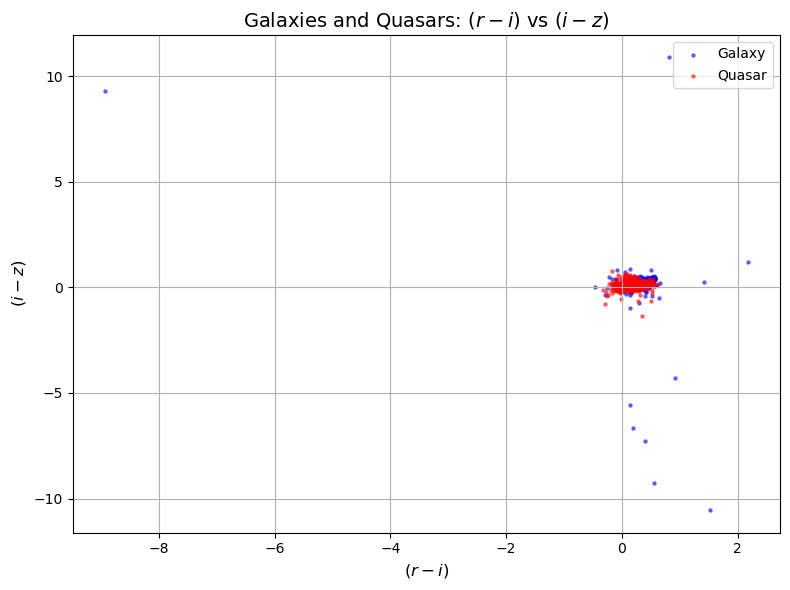

In [33]:
#Q2

import matplotlib.pyplot as plt

# Create binary masks for classes
is_galaxy = spec_class == 'GALAXY'
is_quasar = spec_class == 'QSO'

plt.figure(figsize=(8, 6))

# Plot galaxies in blue
plt.scatter(r_i[is_galaxy], i_z[is_galaxy], color='blue', s=5, label='Galaxy', alpha=0.5)

# Plot quasars in red
plt.scatter(r_i[is_quasar], i_z[is_quasar], color='red', s=5, label='Quasar', alpha=0.5)

plt.xlabel(r'$(r - i)$', fontsize=12)
plt.ylabel(r'$(i - z)$', fontsize=12)
plt.title('Galaxies and Quasars: $(r - i)$ vs $(i - z)$', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
#Q3

from astroML.utils import split_samples

# Stack (r - i) and (i - z) into the design matrix
X = np.column_stack([r_i, i_z])  # shape (N, 2)

# 0 for galaxy, 1 for quasar
y = np.zeros(len(spec_class), dtype=int)
y[spec_class == 'QSO'] = 1  # Boolean indexing

# Train-test split (80/20)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.8, 0.2], random_state=42)

# Confirm shapes
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 4000
Testing set size: 1000


In [36]:
#Q4

from sklearn import preprocessing

X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

X_scaled = preprocessing.scale(X)


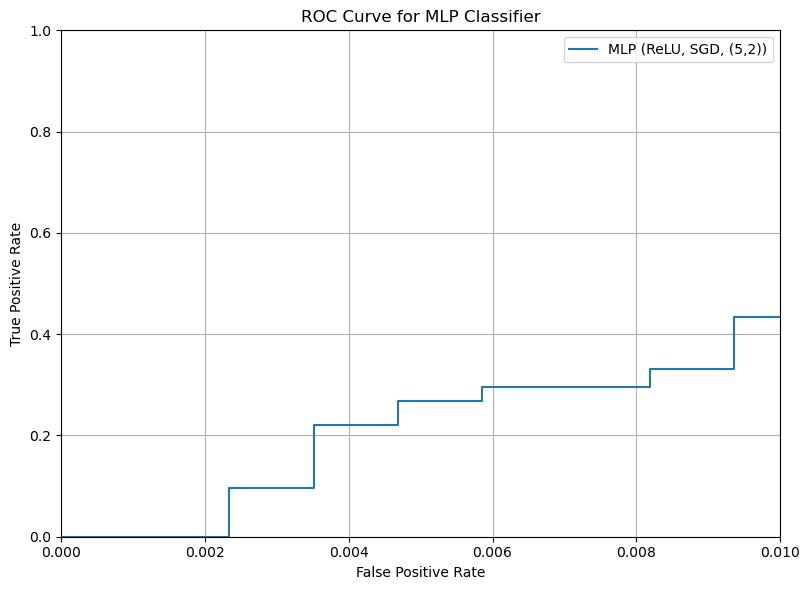

In [37]:
#Q5

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Define and train the MLP classifier
clf = MLPClassifier(
    hidden_layer_sizes=(5, 2),
    activation='relu',
    solver='sgd',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_scaled, y_train)

# Get predicted probabilities for the test set
probs = clf.predict_proba(X_test_scaled)

# Index for class 1 (quasar)
quasar_index = list(clf.classes_).index(1)
y_scores = probs[:, quasar_index]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='MLP (ReLU, SGD, (5,2))')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP Classifier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.show()


In [39]:
#Q6

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
parameters = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(2, 2), (5, 5), (5, 2), (5, 5, 5)],
    'activation': ['relu', 'tanh'],
    'random_state': [42],
    'max_iter': [1000]
}

mlp = MLPClassifier()

# Perform grid search with cross-validation (default is cv=5)
clf_grid = GridSearchCV(mlp, parameters, n_jobs=-1)
clf_grid.fit(X_train_scaled, y_train)


print("Best training score: {:.4f}".format(clf_grid.best_score_))
print("Best hyperparameters:\n", clf_grid.best_params_)


/Users/harvir_d/miniconda3/envs/astr8070/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/harvir_d/miniconda3/envs/astr8070/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/harvir_d/miniconda3/envs/astr8070/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545

Best training score: 0.9357
Best hyperparameters:
 {'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}


/Users/harvir_d/miniconda3/envs/astr8070/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [40]:
print("Best training score: {:.4f}".format(clf_grid.best_score_))
print("Best hyperparameters:\n", clf_grid.best_params_)

Best training score: 0.9357
Best hyperparameters:
 {'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}


/Users/harvir_d/miniconda3/envs/astr8070/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


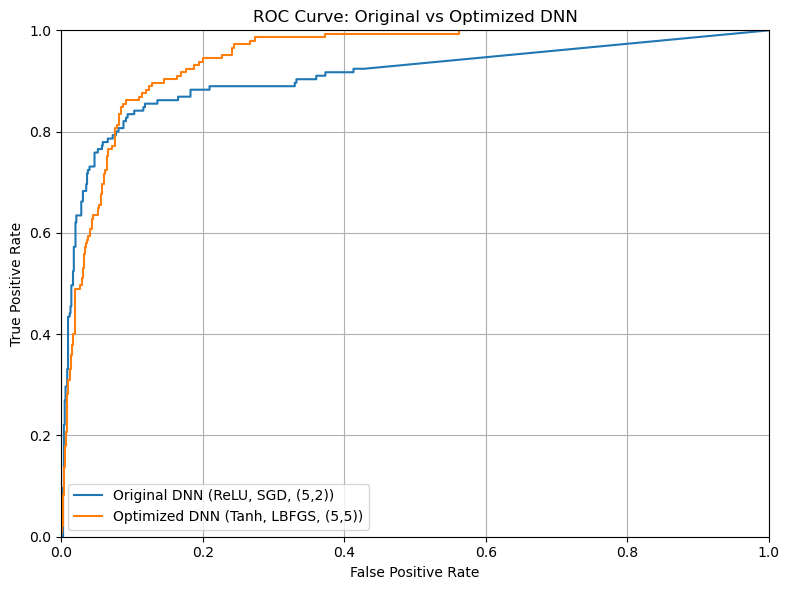

Original DNN AUC: 0.9092
Optimized DNN AUC: 0.9455


In [42]:
#Q7

# original DNN
original_dnn = MLPClassifier(
    hidden_layer_sizes=(5, 2),
    activation='relu',
    solver='sgd',
    max_iter=1000,
    random_state=42
)
original_dnn.fit(X_train_scaled, y_train)
original_probs = original_dnn.predict_proba(X_test_scaled)
original_quasar_index = list(original_dnn.classes_).index(1)
original_scores = original_probs[:, original_quasar_index]
fpr_orig, tpr_orig, _ = roc_curve(y_test, original_scores)

# optimized DNN
optimized_dnn = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
optimized_dnn.fit(X_train_scaled, y_train)
optimized_probs = optimized_dnn.predict_proba(X_test_scaled)
optimized_quasar_index = list(optimized_dnn.classes_).index(1)
optimized_scores = optimized_probs[:, optimized_quasar_index]
fpr_opt, tpr_opt, _ = roc_curve(y_test, optimized_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label='Original DNN (ReLU, SGD, (5,2))')
plt.plot(fpr_opt, tpr_opt, label='Optimized DNN (Tanh, LBFGS, (5,5))')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Original vs Optimized DNN')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

auc_orig = auc(fpr_orig, tpr_orig)
auc_opt = auc(fpr_opt, tpr_opt)

print(f"Original DNN AUC: {auc_orig:.4f}")
print(f"Optimized DNN AUC: {auc_opt:.4f}")


SRT: Well done, Harvir.

48/50